In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import pandas as pd

In [14]:
from sklearn.preprocessing import MinMaxScaler


data_train = pd.read_csv('./data/data_train.csv')

data_fingerprint = data_train.copy()
data_fingerprint = data_fingerprint[["rssi_value", "delay_1", "delay_2", "delay_3", "lon_y", "lat_y"]].values

scalet = MinMaxScaler()
data_norm = scalet.fit_transform(data_fingerprint)

data_tensor = torch.tensor(data_norm, dtype=torch.float32)
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
data_loader

In [15]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

input_dim = 100
output_dim = data_norm.shape[1]

In [16]:
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)

lr = 0.0002
b1 = 0.5
b2 = 0.999

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
adversarial_loss = nn.BCELoss()

In [17]:
def train_gan(data_loader, epochs=100):
    for epoch in range(epochs):
        for real_data in data_loader:
            real_data = real_data[0]
            batch_size = real_data.size(0)

            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            optimizer_D.zero_grad()
            outputs = discriminator(real_data)
            d_loss_real = adversarial_loss(outputs, real_labels)

            noise = torch.randn(batch_size, input_dim)
            fake_data = generator(noise)
            outputs = discriminator(fake_data.detach())
            d_loss_fake = adversarial_loss(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()
            outputs = discriminator(fake_data)
            g_loss = adversarial_loss(outputs, real_labels)
            g_loss.backward()
            optimizer_G.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss D: {d_loss.item()}, Loss G: {g_loss.item()}")

train_gan(data_loader, epochs=100)

Epoch 1/100, Loss D: 1.3832509517669678, Loss G: 0.6997300982475281
Epoch 2/100, Loss D: 1.3360061645507812, Loss G: 0.7298787236213684
Epoch 3/100, Loss D: 1.3894177675247192, Loss G: 0.6753623485565186
Epoch 4/100, Loss D: 1.3642568588256836, Loss G: 0.7530511617660522
Epoch 5/100, Loss D: 1.2885758876800537, Loss G: 0.7812250256538391
Epoch 6/100, Loss D: 1.3024561405181885, Loss G: 0.7621783018112183
Epoch 7/100, Loss D: 1.3788655996322632, Loss G: 0.7049112915992737
Epoch 8/100, Loss D: 1.3811469078063965, Loss G: 0.7229799628257751
Epoch 9/100, Loss D: 1.3814396858215332, Loss G: 0.7047162055969238
Epoch 10/100, Loss D: 1.3641021251678467, Loss G: 0.7214943170547485
Epoch 11/100, Loss D: 1.3954455852508545, Loss G: 0.7035101652145386
Epoch 12/100, Loss D: 1.3515487909317017, Loss G: 0.7359690070152283
Epoch 13/100, Loss D: 1.3586302995681763, Loss G: 0.7005778551101685
Epoch 14/100, Loss D: 1.3751449584960938, Loss G: 0.709087610244751
Epoch 15/100, Loss D: 1.364532709121704, Los

In [19]:
def generate_new_data(generator, num_samples):
    noise = torch.randn(num_samples, input_dim)
    generated_data = generator(noise)

    return generated_data

num_samples = 1000
generated_data = generate_new_data(generator, num_samples)

new_data_not_norm = scalet.inverse_transform(generated_data.detach().numpy())

In [20]:
new_data_df = pd.DataFrame(new_data_not_norm, columns=["rssi_value", "delay_1", "delay_2", "delay_3", "lon_y", "lat_y"])
new_data_df

,rssi_value,delay_1,delay_2,delay_3,lon_y,lat_y
0,-98.850418,5.034942,3.000568,3.006221,-34.951439,-8.055719
1,-97.097801,4.986346,2.980001,1.994579,-34.951637,-8.055523
2,-115.048302,5.003775,2.988803,1.986902,-34.951756,-8.055592
3,-114.995857,5.005533,2.985693,2.993715,-34.951401,-8.055806
4,-107.737976,5.018551,2.989176,1.996596,-34.951775,-8.055476
...,...,...,...,...,...,...
995,-98.774818,5.028275,2.988148,2.981988,-34.951447,-8.055715
996,-94.068878,4.986499,2.987947,1.982413,-34.951672,-8.055548
997,-83.933205,0.957819,2.847137,4.767853,-34.950836,-8.046839
998,-114.978722,5.001050,2.990523,1.987878,-34.951702,-8.055660


In [26]:
old_data = data_train[['rssi_value', 'delay_1', 'delay_2', 'delay_3', 'lon_y', 'lat_y']]
expanded_data = pd.concat([old_data, new_data_df], ignore_index=True)
expanded_data

,rssi_value,delay_1,delay_2,delay_3,lon_y,lat_y
0,-103.705000,5.000000,3.000000,2.000000,-34.951505,-8.055786
1,-105.225000,5.000000,3.000000,2.000000,-34.951608,-8.055784
2,-102.610000,5.000000,3.000000,2.000000,-34.951693,-8.055506
3,-89.140000,4.000000,7.000000,2.000000,-34.959630,-8.050390
4,-109.088333,5.000000,3.000000,2.000000,-34.951736,-8.055380
...,...,...,...,...,...,...
61380,-98.774818,5.028275,2.988148,2.981988,-34.951447,-8.055715
61381,-94.068878,4.986499,2.987947,1.982413,-34.951672,-8.055548
61382,-83.933205,0.957819,2.847137,4.767853,-34.950836,-8.046839
61383,-114.978722,5.001050,2.990523,1.987878,-34.951702,-8.055660


In [27]:
from sklearn.model_selection import train_test_split


expanded_data_X = expanded_data.drop(columns=['lon_y', 'lat_y'])
expanded_data_Y = expanded_data[['lon_y', 'lat_y']]

expanded_data_X = scalet.fit_transform(expanded_data_X)

X_train, X_test, y_train, y_test = train_test_split(expanded_data_X, expanded_data_Y, test_size=0.2, random_state=42)

In [28]:
from sklearn.neighbors import KNeighborsRegressor


knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

predicted_location = knn.predict(X_test)

In [29]:
predicted_location

array([[-34.94881  ,  -8.058766 ],
       [-34.9513558,  -8.055804 ],
       [-34.95188  ,  -8.051288 ],
       ...,
       [-34.951328 ,  -8.055646 ],
       [-34.955618 ,  -8.056684 ],
       [-34.951331 ,  -8.055684 ]])

In [30]:
from geopy.distance import geodesic

# Calculando os erros em metros
errors_in_meters = []
for real, pred in zip(y_test.values, predicted_location):
    real_coords = (real[1], real[0])  # (lat, lon)
    pred_coords = (pred[1], pred[0])  # (lat, lon)
    error_distance = geodesic(real_coords, pred_coords).meters
    errors_in_meters.append(error_distance)

# Convertendo para numpy array para facilitar o manuseio
errors_in_meters = np.array(errors_in_meters)

mean_error = errors_in_meters.mean()
std_error = errors_in_meters.std()
max_error = errors_in_meters.max()
min_error = errors_in_meters.min()
med_error = np.median(errors_in_meters)

print(f'Mean Error: {mean_error:.2f} meters')
print(f'Std Error: {std_error:.2f} meters')
print(f'Max Error: {max_error:.2f} meters')
print(f'Min Error: {min_error:.2f} meters')
print(f'Median Error: {med_error:.2f} meters')


Mean Error: 17.42 meters
Std Error: 29.26 meters
Max Error: 267.88 meters
Min Error: 0.00 meters
Median Error: 6.19 meters


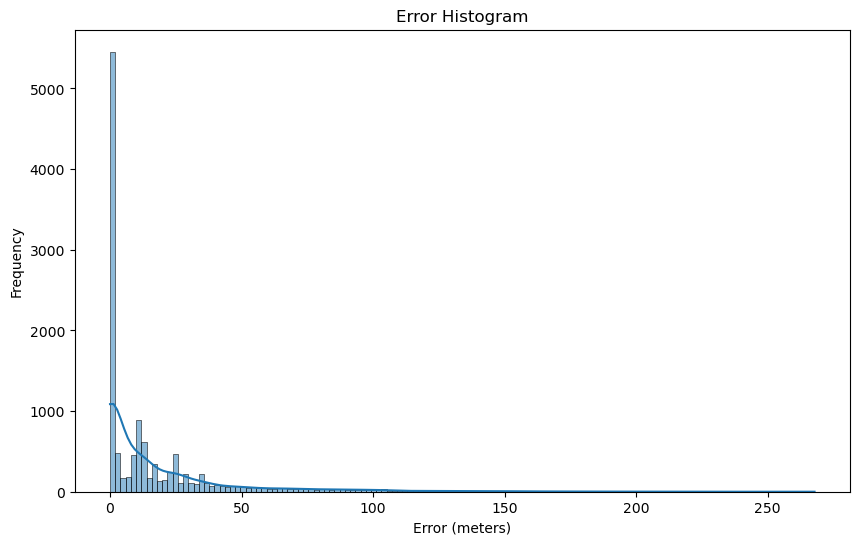

In [32]:
import seaborn as sns

### error histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(errors_in_meters, kde=True)
plt.title('Error Histogram')
plt.xlabel('Error (meters)')
plt.ylabel('Frequency')
plt.show()

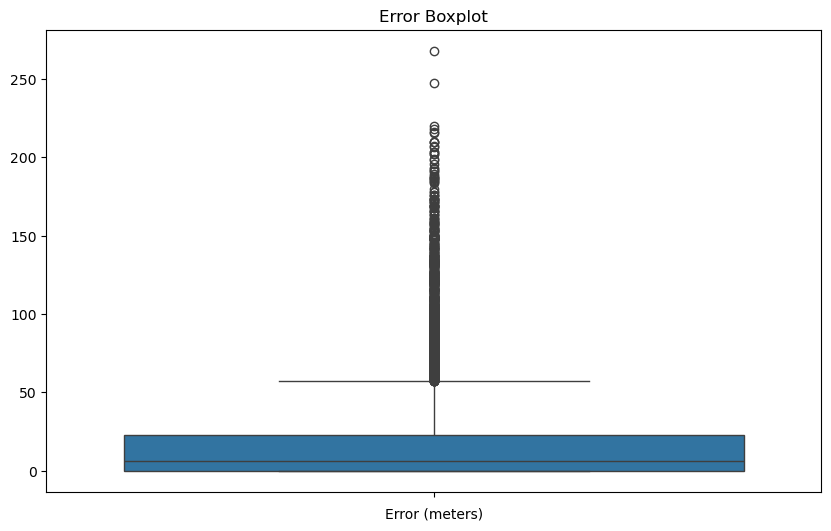

In [33]:
### error boxplot plot
plt.figure(figsize=(10, 6))
sns.boxplot(errors_in_meters)
plt.title('Error Boxplot')
plt.xlabel('Error (meters)')
plt.show()

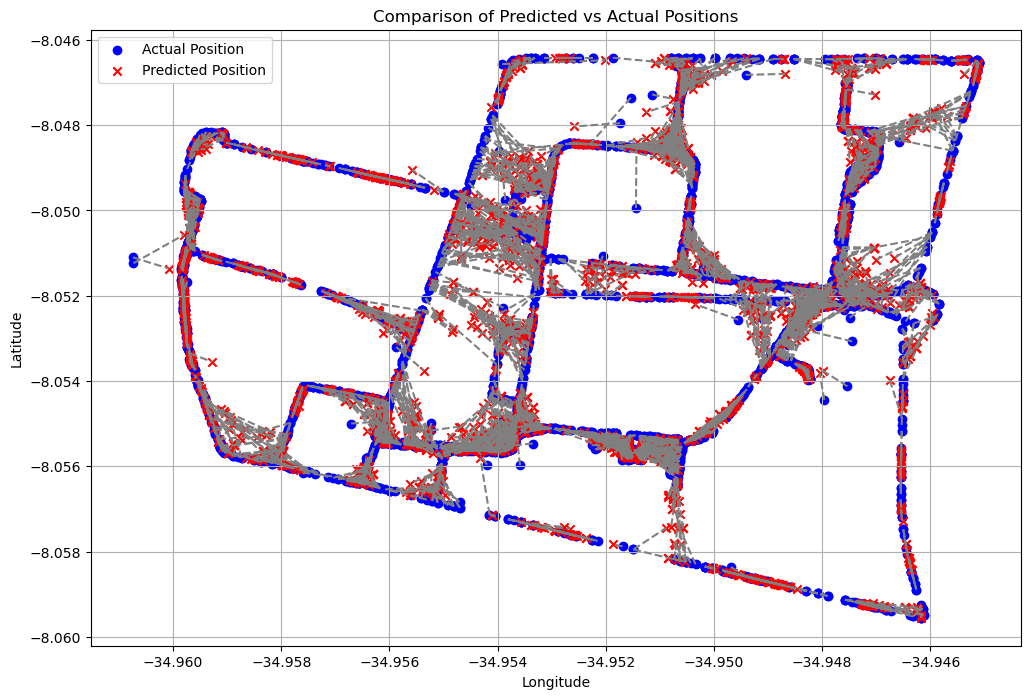

In [34]:
true_lat = y_test['lat_y'].values
true_lon = y_test['lon_y'].values

pred_lat = predicted_location[:, 1]
pred_lon = predicted_location[:, 0]

plt.figure(figsize=(12, 8))
plt.scatter(true_lon, true_lat, color='blue', label='Actual Position')
plt.scatter(pred_lon, pred_lat, color='red', marker='x', label='Predicted Position')

for i in range(len(true_lat)):
    plt.plot([true_lon[i], pred_lon[i]], [true_lat[i], pred_lat[i]], 'gray', linestyle='--')

plt.title('Comparison of Predicted vs Actual Positions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()